# Aggregating Census Data to Custom Geographies

In this notebook, you'll see how to use Python and Census Bureau APIs to aggregate Census data for custom geographies.  For this exercise, we'll develop a choropleth map of [Chicago's 77 community areas](https://en.wikipedia.org/wiki/Community_areas_in_Chicago) showing the percentage of children under 18. 

To do this, there are 7 basic steps:

* [Figure out the relevant census tracts](#Figure-out-the-relevant-census-tracts)
* [Get data about age by Census tract](#Get-data-about-age-by-Census-tract)
* [Aggregate tract estimates into community area estimates](#Aggregate-tracts-to-community-areas)
* [Aggregate estimates by sex and age bracket to get total count of children under 18](#Aggregate-estimates-by-sex-and-age-bracket)
* [Convert estimates into percentages](#Convert-estimates-into-percentages)
* [Join the data to a map of community areas](#Join-the-data-to-a-map-of-community-areas)
* [Render the map]()

For a bonus, we'll also look at how to [render a ranked list](#Render-a-ranked-list), correctly taking into account statistically significant differences. Warning: it's complicated and not necessarily clear, but its something to wrestle with.

This notebook is meant more as an example than an explanation. There are some comments and notes inline, but if you're adapting to other cases, you may want to consult official documentation for some of the key libraries used:

* [cenpy](https://cenpy-devs.github.io/cenpy/)
* [pandas](https://pandas.pydata.org/pandas-docs/stable/)
* [geopandas](http://geopandas.org/)
* [matplotlib](https://matplotlib.org/index.html)



In [1]:
# let's just get this stuff out of the way...
import cenpy
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from census_data_aggregator import approximate_sum, approximate_proportion
from census_error_analyzer import is_statistically_different, statistical_range
from collections import defaultdict

%matplotlib inline

# Without an API Key, the Census API is limited to 500 daily requests per IP address. 
# I've obtained an API key for use with this exercise, but it may be disabled at any time. 
# If you have your own, use it below, and if you get an error using this one, 
# you may need to request your own key
# see https://www.census.gov/data/developers/guidance/api-user-guide.Query_Components.html 
# for more about limits and a link to request your own key. 
# There's usually a short wait before keys are issued
CENSUS_API_KEY = '6871e29db5145699fdcbbd7da64b3eb9e49c25d4'

# Set this to false if you're trying to do this without an internet connection
# and data which would have been fetched from an API query will be read from cached files instead
INTERNET_IS_WORKING = True

## Figure out the relevant census tracts

If you talk to me about Census data for long, you'll get me going on this topic. It's way harder than it ought to be to know "officially" which Census tracts are in a given Census "place".  One reason for that is that place boundaries can cut through tracts, so any official resource would have to deal with partial tracts, and how to allocate estimates for the tract into the parts, etc. 

### Cenpy for geographic selection

[`Cenpy`](https://cenpy-devs.github.io/cenpy/) is a fairly new, rapidly evolving Python library for working with Census data. There are several other alternatives, but I like the approach of `cenpy`'s "products" API, which is organized around the way people work, and not so closely modeled after the Census's own API.

Below is an example lightly adapted from one of Cenpy's demonstration notebooks that shows how easy it could be.

It takes a bit of time to execute (seconds not minutes), because the one python function call (`from_place()`) is making at least a few Census API calls, first to interpret the place name, then to get the geographies, and then to get the data.  But once it's done, it's all given back to you in a handy [GeoPandas](http://geopandas.org/) data frame, which makes the mapping really easy.


Matched: Chicago, IL to Chicago city within layer Incorporated Places


/Users/germuska/Library/Caches/pypoetry/virtualenvs/nicar-2020-advanced-census-f3_vb5wT-py3.7/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


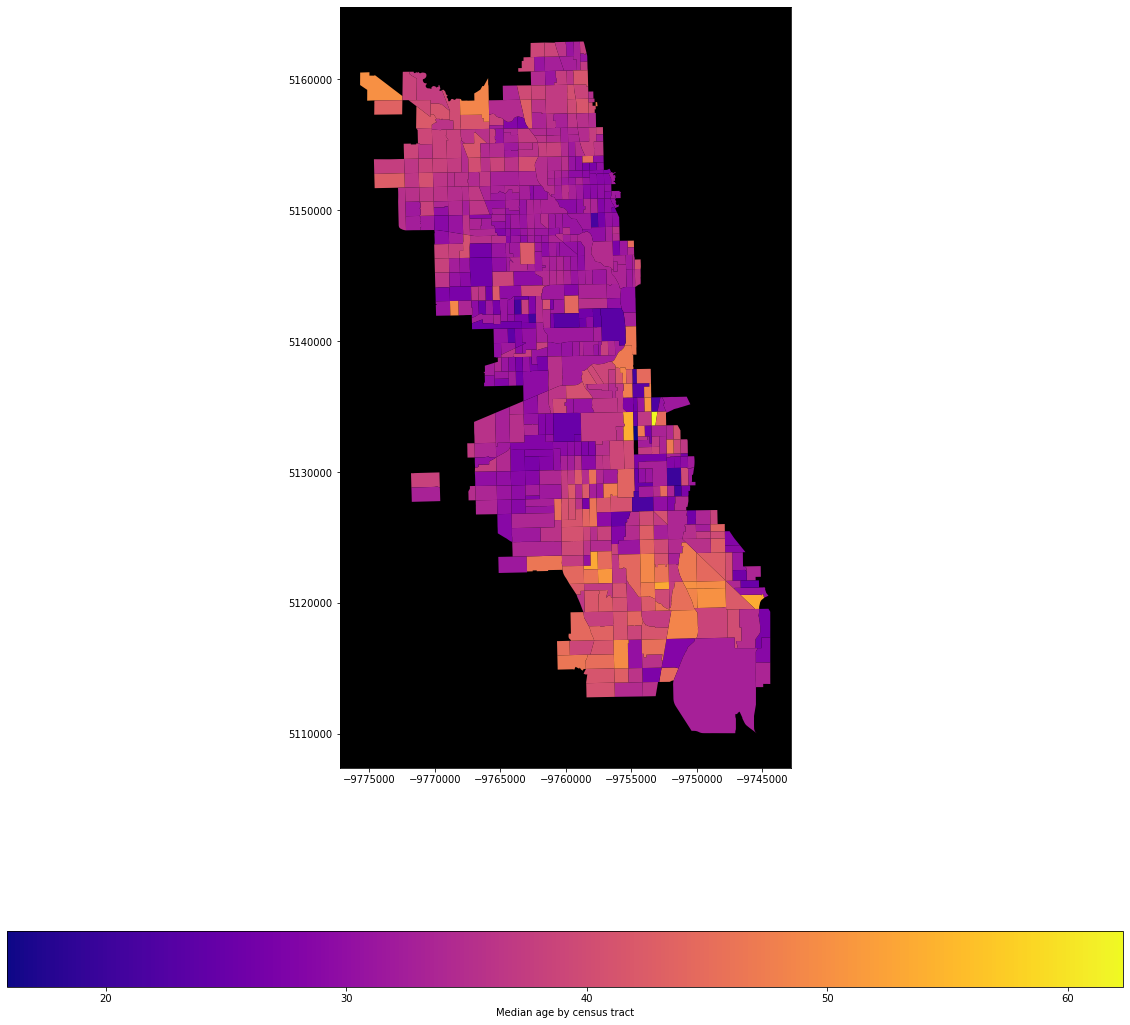

In [2]:
if INTERNET_IS_WORKING:
    chi_median_age = cenpy.products.ACS(2018).from_place('Chicago, IL', level='tract', variables=['B01002_001E'])
else:
    chi_median_age = geopandas.read_file('data/chi_median_age.geojson')

f, ax = plt.subplots(1,1,figsize=(20,20)) # make a bigger map than the default

chi_median_age.dropna(subset=['B01002_001E'], axis=0).plot('B01002_001E', 
                                                            ax=ax, 
                                                            cmap='plasma', 
                                                            legend=True, 
                                                            legend_kwds={
                                                                'label': "Median age by census tract",
                                                                'orientation': "horizontal"
                                                            })

ax.set_facecolor('k')

### However...

People familiar with Chicago maps may notice something strange about the map above. It doesn't show O'Hare airport, which should be at the top left of the map. 

It turns out that the City of Chicago publishes an ["official" list of Census tracts](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik).  Let's look at the difference.

/Users/germuska/Library/Caches/pypoetry/virtualenvs/nicar-2020-advanced-census-f3_vb5wT-py3.7/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


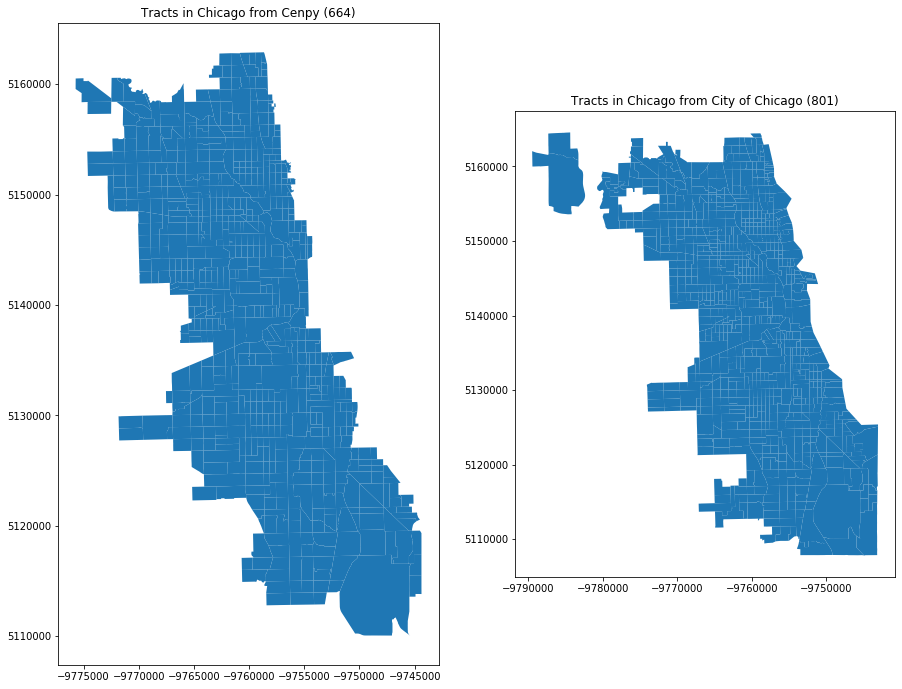

In [3]:
# we exported the official list of tracts as a GeoJSON file.
chi_tracts_geo = geopandas.read_file('data/Boundaries - Census Tracts - 2010.geojson') 
chi_tracts_geo = chi_tracts_geo.to_crs(chi_median_age.geometry.crs) # make them the same projection
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.set_title(f'Tracts in Chicago from Cenpy ({len(chi_median_age)})')
ax2.set_title(f'Tracts in Chicago from City of Chicago ({len(chi_tracts_geo)})')
chi_median_age.plot(ax=ax1)
chi_tracts_geo.plot(ax=ax2)

#### Just because we can...

let's see just the tracts that are missing from the `cenpy` query.  (Computing the population of just these missing tracts is left as an exercise for the reader!)

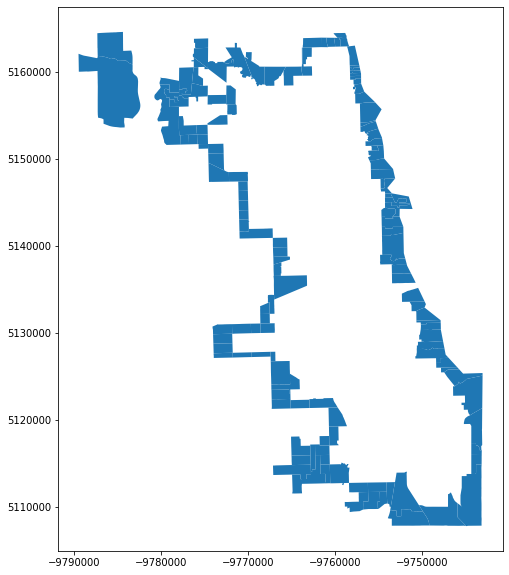

In [4]:
f, ax = plt.subplots(1,1,figsize=(10,10))
missing = chi_tracts_geo[~chi_tracts_geo['geoid10'].isin(chi_median_age['GEOID'])] # ~ is the "inverse" operator in panda
missing.plot(ax=ax)

### So what do we do about it?

In fairness, `cenpy`'s `from_place` takes an argument, `strict_within` which, if set to `False`, will use an "intersects" query, which returns more tracts -- but in this case, instead of too few, it returns more than 200 tracts too many... so it doesn't really solve the problem.  

Since we have Chicago's list of tracts, we'll use it instead of `cenpy`

Fun fact: Chicago's "official" list still leaves out a couple of partial tracts near O'Hare airport which are in neighboring DuPage county, but are still partly inside Chicago's borders. Also, some tracts partly in Chicago are also partly in 9 neighboring census places, so even using Chicago's list, we're likely to include some people or households which aren't in Chicago.

*Now's also a good time to remember that American Community Survey data is estimated anyway, so you'll always need to account for uncertainty. Always write and speak about your analysis accordingly.*



## Get data about age by Census tract

To use the Census API, through `cenpy` or any other means, **you need to identify the Census Bureau data product and the variables within it for your purposes**. You can browse through [a page on the Census site](https://api.census.gov/data.html) to know basically what's available. Since we're using `cenpy`, we need to use its system of codes to identify products. 

### Cenpy's `explorer` tools

`cenpy.explorer` provides a few methods to identify datasets and variables.  This is a bit of a diversion because I thought some folks would want to know about the features. If you don't care about `cenpy.explorer` feel free to skip ahead to [Let's cut to the chase](#Let's-cut-to-the-chase)

**Remember**: It's always best to read official documentation to make sure you're not assuming anything -- but even when you have, these kinds of tools can come in handy.

In [5]:
# `cenpy.explorer.available()` function returns a Pandas data frame with high level information about what the Census API serves.  
if INTERNET_IS_WORKING:
    avail = cenpy.explorer.available()
else:
    avail = pd.read_csv('data/explorer_available.csv',index_col='Unnamed: 0')

# but it's a real big data frame...
print(f"The API offers access to {len(avail)} datasets") # how big?
# ...so let's just peek. The index column (unlabeled, but at the leftmost position) is the cenpy code you'll need to work with that data product.
avail.head() 

The API offers access to 413 datasets


,c_isTimeseries,c_isCube,publisher,temporal,spatial,programCode,modified,keyword,contactPoint,distribution,...,c_isAvailable,c_isAggregate,c_valuesLink,c_groupsLink,c_examplesLink,c_tagsLink,c_variablesLink,c_geographyLink,c_dataset,vintage
2000sf1,NaN,NaN,US Census Bureau,2000,US,NaN,NaN,(),"{'fn': 'Census Bureau Call Center', 'hasEmail'...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",...,True,True,https://api.census.gov/data/2000/sf1/values.json,https://api.census.gov/data/2000/sf1/groups.json,https://api.census.gov/data/2000/sf1/examples....,https://api.census.gov/data/2000/sf1/tags.json,https://api.census.gov/data/2000/sf1/variables...,https://api.census.gov/data/2000/sf1/geography...,"(sf1,)",2000.0
2000sf3,NaN,NaN,US Census Bureau,2000,US,NaN,2017-05-23,(),"{'fn': 'Census Bureau Call Center', 'hasEmail'...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",...,True,True,https://api.census.gov/data/2000/sf3/values.json,https://api.census.gov/data/2000/sf3/groups.json,https://api.census.gov/data/2000/sf3/examples....,https://api.census.gov/data/2000/sf3/tags.json,https://api.census.gov/data/2000/sf3/variables...,https://api.census.gov/data/2000/sf3/geography...,"(sf3,)",2000.0
ACSCD1132011,NaN,NaN,U.S. Census Bureau,2011/2011,United States,006:004,2014-10-06,(),"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",...,True,True,https://api.census.gov/data/2011/acs1/cd113/va...,https://api.census.gov/data/2011/acs1/cd113/gr...,https://api.census.gov/data/2011/acs1/cd113/ex...,https://api.census.gov/data/2011/acs1/cd113/ta...,https://api.census.gov/data/2011/acs1/cd113/va...,https://api.census.gov/data/2011/acs1/cd113/ge...,"(acs1, cd113)",2011.0
ACSCD1152015,NaN,NaN,U.S. Census Bureau,2015/2015,United States,006:004,2017-02-10,(),"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",...,True,True,https://api.census.gov/data/2015/acs1/cd115/va...,https://api.census.gov/data/2015/acs1/cd115/gr...,https://api.census.gov/data/2015/acs1/cd115/ex...,https://api.census.gov/data/2015/acs1/cd115/ta...,https://api.census.gov/data/2015/acs1/cd115/va...,https://api.census.gov/data/2015/acs1/cd115/ge...,"(acs1, cd115)",2015.0
ACSCP1Y2010,NaN,True,U.S. Census Bureau,unidentified,United States,006:004,2018-09-18 00:00:00.0,(),"{'fn': 'American Community Survey Office', 'ha...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",...,True,True,https://api.census.gov/data/2010/acs/acs1/cpro...,https://api.census.gov/data/2010/acs/acs1/cpro...,https://api.census.gov/data/2010/acs/acs1/cpro...,https://api.census.gov/data/2010/acs/acs1/cpro...,https://api.census.gov/data/2010/acs/acs1/cpro...,https://api.census.gov/data/2010/acs/acs1/cpro...,"(acs, acs1, cprofile)",2010.0


Check out the `c_dataset` column. (You'll probably have to scroll right.) Those values are [tuples](http://openbookproject.net/thinkcs/python/english3e/tuples.html), and the first value in the tuple is sometimes `acs`, and when it is, the second value indicates whether the data is from a 1-year, 3-year, or 5-year release.  We happen to know that census tracts are only included in the 5-year release, so let's filter for only those.  And while we're at it, let's use the `vintage` column to just see the most recent data.

In [6]:
pd.set_option('display.max_colwidth', 0) # there's a lot of text! This makes sure we can see it all.

# get the subset of available Census products which are for ACS 5-year releases:
avail_acs = avail[avail['c_dataset'].apply(lambda x: x[0] == 'acs' and x[1] == 'acs5')]

# let's filter it to just the latest ('max') vintage year, and just look at the most useful columns:
avail_acs[avail_acs['vintage'] == avail_acs['vintage'].max()][['title','description']]

,title,description
ACSCP5Y2018,American Community Survey: 1-Year Estimates: Comparison Profiles 5-Year,"The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. The comparison profiles include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts, all counties and all places with a population of 5,000 or more. Comparison profiles are similar to data profiles but also include comparisons with past-year data. The current year data are compared with prior 5-Year data and include statistical significance testing. There are over 3,000 variables in this dataset."
ACSDP5Y2018,ACS 5-Year Data Profiles,"The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. The data profiles include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts, all counties, all places and all tracts. Data profiles contain broad social, economic, housing, and demographic information. The data are presented as both counts and percentages. There are over 2,400 variables in this dataset."
ACSDT5Y2018,American Community Survey: 1-Year Estimates: Detailed Tables 5-Year,"The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. Summary files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts (114th congress), all counties, all places, and all tracts and block groups. Summary files contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population and housing counts. There are over 64,000 variables in this dataset."
ACSST5Y2018,ACS 5-Year Subject Tables,"The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. The subject tables include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts, all counties, all places and all tracts. Subject tables provide an overview of the estimates available in a particular topic. The data are presented as both counts and percentages. There are over 66,000 variables in this dataset."


**OK, now we're cookin'.** 

Still, which one do we want? Here's where you're probably best off doing at least a little homework outside of `cenpy`.  [This page from Census](https://www.census.gov/data/developers/data-sets/acs-5year.html) describes the four different ACS products shown above. 

In this case, we'll go ahead and use the detailed tables, that is, **ACSDT5Y2018**


In [7]:
if INTERNET_IS_WORKING:
    con = cenpy.remote.APIConnection('ACSDT5Y2018',apikey=CENSUS_API_KEY)
    variables = con.variables
else:
    variables = pd.read_csv('data/ACSDT5Y2018_variables.csv',index_col='Unnamed: 0')

# No matter which product you use, a cenpy APIConnection can show you the variables 
# which it can retrieve for you. They come back as a pandas DataFrame.
print(f"ACSDT5Y2018 provides {len(variables)} variables.") # how many are there?
variables.head()

ACSDT5Y2018 provides 27037 variables.


,label,concept,predicateType,group,limit,predicateOnly,attributes,required
for,Census API FIPS 'for' clause,Census API Geography Specification,fips-for,N/A,0,True,NaN,NaN
in,Census API FIPS 'in' clause,Census API Geography Specification,fips-in,N/A,0,True,NaN,NaN
ucgid,Uniform Census Geography Identifier clause,Census API Geography Specification,ucgid,N/A,0,True,NaN,NaN
B24022_060E,Estimate!!Total!!Female!!Service occupations!!Food preparation and serving related occupations,"SEX BY OCCUPATION AND MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) FOR THE FULL-TIME, YEAR-ROUND CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER",int,B24022,0,NaN,"B24022_060M,B24022_060MA,B24022_060EA",NaN
B19001B_014E,"Estimate!!Total!!$100,000 to $124,999",HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER),int,B19001B,0,NaN,"B19001B_014M,B19001B_014MA,B19001B_014EA",NaN


In [8]:
# values for 'group' are ACS table IDs; 
# for this data, when it's N/A, it's for other kinds of API variables.
# so let's leave those out:
short_vars = variables[~(variables['group'] == 'N/A')] 

# So now this is an easy way to get a list of all of the table IDs and their titles
short_vars[['group', 'concept']].drop_duplicates().sort_values('group').head(10) 

,group,concept
B00001_001E,B00001,UNWEIGHTED SAMPLE COUNT OF THE POPULATION
B00002_001E,B00002,UNWEIGHTED SAMPLE HOUSING UNITS
B01001_012E,B01001,SEX BY AGE
B01001A_002E,B01001A,SEX BY AGE (WHITE ALONE)
B01001B_029E,B01001B,SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE)
B01001C_008E,B01001C,SEX BY AGE (AMERICAN INDIAN AND ALASKA NATIVE ALONE)
B01001D_008E,B01001D,SEX BY AGE (ASIAN ALONE)
B01001E_013E,B01001E,SEX BY AGE (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)
B01001F_001E,B01001F,SEX BY AGE (SOME OTHER RACE ALONE)
B01001G_022E,B01001G,SEX BY AGE (TWO OR MORE RACES)


### Let's cut to the chase

This is pretty cool, but it can be tedious, so again, sometimes external research into how Census data is organized will pay off.  

In this case, we know that [**B01001**](https://censusreporter.org/tables/B01001/) has the data we need to start, but we don't know the specific API variable codes for the columns we need.

Let's take a look:

In [9]:
short_vars[short_vars['group'] == 'B01001'][['label','attributes']].sort_index() 

,label,attributes
B01001_001E,Estimate!!Total,"B01001_001EA,B01001_001M,B01001_001MA"
B01001_002E,Estimate!!Total!!Male,"B01001_002EA,B01001_002M,B01001_002MA"
B01001_003E,Estimate!!Total!!Male!!Under 5 years,"B01001_003EA,B01001_003M,B01001_003MA"
B01001_004E,Estimate!!Total!!Male!!5 to 9 years,"B01001_004EA,B01001_004M,B01001_004MA"
B01001_005E,Estimate!!Total!!Male!!10 to 14 years,"B01001_005EA,B01001_005M,B01001_005MA"
B01001_006E,Estimate!!Total!!Male!!15 to 17 years,"B01001_006EA,B01001_006M,B01001_006MA"
B01001_007E,Estimate!!Total!!Male!!18 and 19 years,"B01001_007EA,B01001_007M,B01001_007MA"
B01001_008E,Estimate!!Total!!Male!!20 years,"B01001_008EA,B01001_008M,B01001_008MA"
B01001_009E,Estimate!!Total!!Male!!21 years,"B01001_009EA,B01001_009M,B01001_009MA"
B01001_010E,Estimate!!Total!!Male!!22 to 24 years,"B01001_010EA,B01001_010M,B01001_010MA"


Notice the `attributes` column. This shows related variables you can request. The one that ends with **M** is the margin of error, and since we want to be responsible when we aggregate data, we'll be sure to aggregate the error as well. The other two, which end with **A** are "annotations."  We won't deal with those, but the Census Bureau has a [note on them](https://www.census.gov/data/developers/data-sets/acs-1year/notes-on-acs-estimate-and-annotation-values.html) if you want to know more.  

In practice, you probably won't really use this column much, since it's the same for all ACS data, but remember that the API serves more than just ACS data.

There's no easier way I know than manually creating a list of the variables you need.  We'll do one little trick to add the margin variables though.


In [10]:
estimate_cols = [
    'B01001_001E', # total
    'B01001_003E', 'B01001_004E', 'B01001_005E', 'B01001_006E', # male brackets < 18
    'B01001_027E', 'B01001_028E', 'B01001_029E', 'B01001_030E'  # female brackets < 18
]
moe_cols = [x.replace('E','M') for x in estimate_cols]


### Preparing the tract query

The Census Bureau API still doesn't support globally unique identifiers for geographies. This makes querying a little cumbersome. 

For tracts, you must specify a state and county. You can then list specific six-digit tract IDs within that state/county combination, or you can request all of them.

Let's look again at the tracts we have:

In [11]:
chi_tracts_geo.drop('geometry',axis=1).head() # temporarily drop the geometry column for ease of reading.

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031


**Good news!** This data is already broken down into separate state, county, and six-digit tract IDs. That makes this easier.

In [12]:
# since we know all of our tracts are in a single county, we have an easier job. 
# if we didn't, we'd want to group our tract dataframe by state and county and execute one query per state/county, 
# and then concatenate the resulting dataframes

if INTERNET_IS_WORKING:
    tracts = ','.join(chi_tracts_geo['tractce10']) # make a string argument suitable for the API
    pop_by_tract = con.query(cols=estimate_cols+moe_cols, geo_unit=f'tract:{tracts}',geo_filter={'state': '17', 'county': '031'})
else:
    pop_by_tract = pd.read_csv('data/pop_by_tract.csv', index_col='Unnamed: 0', dtype={'state': 'object', 'county': 'object', 'tract': 'object'})

# we want to join this data to the city's data (which assigns each tract to a community area)
# that will be easiest using the geoid as a common index.
pop_by_tract['geoid'] = pop_by_tract['state'] + pop_by_tract['county'] + pop_by_tract['tract']
pop_by_tract = pop_by_tract.set_index('geoid').drop(columns=['state','county','tract']) # get rid of some other columns we don't need any more
pop_by_tract['community_area'] = chi_tracts_geo.set_index('geoid10')['commarea']

# to my surprise, cenpy returns these as strings so we have to convert.
# most Census estimates are integers, but you can verify by checking the predicateType column in variables
for col in estimate_cols:
    datatype = variables.loc[col]['predicateType']
    pop_by_tract[col] = pop_by_tract[col].astype(datatype) # convert the estimate from string to the right datatype
    col = col.replace('E','M') # MOE columns don't appear in the variables index but we know that the datatype for MOE is same as the estimate
    pop_by_tract[col] = pop_by_tract[col].astype(datatype) # convert the error from string to the right datatype


### Aggregate tracts to community areas

The folks at the [LA Times Data Desk](https://github.com/datadesk) have made a number of useful Python census libraries.  Here we'll use one, [`census-data-aggregator`](https://github.com/datadesk/census-data-aggregator), to deal with correctly aggregating the margin of error when aggregating estimates.  

**Note:** The aggregated margin of error is much less than simply the sum of the margins of error, and in general, aggregating estimates results in a proportionally smaller margin of error (that is, a more reliable estimate.)  However, the method recommended by Census and implemented in `census-data-aggregator` is conservative, resulting in a larger MOE than if the Census Bureau created a tabulation from ACS microdata.  (See [this note](https://github.com/datadesk/census-data-aggregator#a-note-from-the-experts) on the `census-data-aggregator` GitHub page.)

In [13]:
# a helper function so that we can sum more than one estimate/moe pair in a given data frame
def sum_with_moe(df, *column_pairs):
    """Given a data frame and a list of one or more tuples representing estimate/error pairs,
       return a dictionary where each key is one of the values from column pairs and the corresponding
       value is the approximate sum, or approximate error for the sum.
    """
    result = {}
    for est,err in column_pairs:
        tuples = [tuple(x) for x in df[[est,err]].to_numpy()]
        est_sum, err_sum = approximate_sum(*tuples)
        result[est] = est_sum
        result[err] = err_sum
    return result


# sum the tracts
sums = []

for comm_area, df in pop_by_tract.groupby('community_area'):
    tuples = zip(estimate_cols, moe_cols) 
    d = sum_with_moe(df, *tuples)
    d['community_area'] = comm_area
    sums.append(d)

pop_by_comm_area_base = pd.DataFrame(sums)    

cols = list(pop_by_comm_area_base.columns) # I wanted to see 'community_area' at the front of the list, for review purposes
cols.remove('community_area') # so take it out
cols.insert(0,'community_area') # and put it back where we want it
pop_by_comm_area_base = pop_by_comm_area_base.reindex(cols, axis=1) # and tell the dataframe our preferred column order 

pop_by_comm_area_base.head() # how does that look?

,community_area,B01001_001E,B01001_001M,B01001_003E,B01001_003M,B01001_004E,B01001_004M,B01001_005E,B01001_005M,B01001_006E,B01001_006M,B01001_027E,B01001_027M,B01001_028E,B01001_028M,B01001_029E,B01001_029M,B01001_030E,B01001_030M
0,1,54872,1736.098788,1284,276.947648,1821,340.091164,1103,279.860680,614,176.184562,1670,336.994065,1299,275.731754,1298,288.298456,526,212.588805
1,10,42525,1075.830842,1221,246.647522,1258,245.197879,1312,255.958981,618,192.229030,1313,283.762224,1115,218.920077,1073,219.000000,600,154.525079
2,11,27989,1139.499452,742,198.987437,728,153.785565,786,179.658008,386,136.231421,1033,263.011407,584,189.121654,954,247.216504,396,137.589971
3,12,19092,657.249572,646,183.670901,650,141.495583,650,164.225455,349,115.165099,635,164.213276,836,211.445028,459,115.524889,353,108.609392
4,13,18451,870.708907,698,184.816125,684,192.184807,555,162.132662,370,114.254103,494,170.138179,475,155.219200,474,139.176147,278,106.084872


### Aggregate estimates by sex and age bracket

This uses the same `approximate_sum` function provided by `census_data_aggregator` to add the eight buckets for sex/age range together to yield a single estimate of the population of children under age 18.

In [14]:
# now sum the brackets
def sum_brackets(row): 
    tuples = [(row[m],row[e]) for (m,e) in zip(estimate_cols[1:], moe_cols[1:])] # skip totals, which is first in each column list
    return pd.Series(approximate_sum(*tuples), index=['under18_E', 'under18_M'])

bracket_sums = pop_by_comm_area_base.apply(sum_brackets,axis='columns', result_type='expand')
# and carry through the community area identifier and the totals
pop_by_comm_area = pop_by_comm_area_base[['community_area', 'B01001_001E', 'B01001_001M']].join(bracket_sums).rename(columns={
    'B01001_001E': 'totalpop_E', # while we're at it, let's make more meaningful column headers
    'B01001_001M': 'totalpop_M'     
})
pop_by_comm_area.head() # how does that look?

,community_area,totalpop_E,totalpop_M,under18_E,under18_M
0,1,54872,1736.098788,9615.0,787.164532
1,10,42525,1075.830842,8510.0,650.930104
2,11,27989,1139.499452,5609.0,546.873843
3,12,19092,657.249572,4578.0,436.813461
4,13,18451,870.708907,4028.0,440.564411


### Convert estimates into percentages

The `census-data-aggregator` library also provides an [`approximate_proportion`](https://github.com/datadesk/census-data-aggregator#approximating-proportions) function, which is the correct way to compute percentages.

_(Technically, it's not a percentage until multiplied by 100 but I usually only do that for presentation, not for analysis.)_


In [15]:
def compute_proportion(row):
    under18 = row[['under18_E', 'under18_M']]
    total = row[['totalpop_E','totalpop_M']]
    # When using DataFrame.apply across rows, there are different ways that results will be interpreted
    # this function is designed to work with result_type 'expand'
    return pd.Series(approximate_proportion(under18, total), index=['pct_under18_E','pct_under18_M'])

pct_base = pop_by_comm_area.apply(compute_proportion, axis='columns', result_type='expand')
pct_by_comm_area = pop_by_comm_area.join(pct_base) # add the newly computed percent columns to the dataframe with the estimates
pct_by_comm_area.head().style.format({
    'pct_under18_E': '{:,.1%}',
    'pct_under18_M': '{:,.1%}',
    'totalpop_E': '{:,.0f}', # while we're formatting, let's clean up some more...
    'under18_E': '{:,.0f}',  # computed estimates and MOEs have decimal places which aren't appropriate
    'totalpop_M': '{:.0f}',  # when the universe is people so hide those
    'under18_M': '{:.0f}',
}) # how does that look?

,community_area,totalpop_E,totalpop_M,under18_E,under18_M,pct_under18_E,pct_under18_M
0,1,"54,872",1736,"9,615",787,17.5%,1.3%
1,10,"42,525",1076,"8,510",651,20.0%,1.4%
2,11,"27,989",1139,"5,609",547,20.0%,1.8%
3,12,"19,092",657,"4,578",437,24.0%,2.1%
4,13,"18,451",871,"4,028",441,21.8%,2.2%


## Join the data to a map of community areas

If you happen to have an official map, you may want to use it, but if you don't, you can aggregate the geographies in your map in much the same way we aggregated tract-level estimates up to the community area level.

### Method 1: Obtain a map and join it.

The City of Chicago offers [a GIS map of Chicago's community areas on the data portal](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6). We exported it from Socrata rather than mess with the Socrata API. One nice thing about this is that it comes with labels (names) for the community areas. As you'll see later, it also preserves some nuance to the borders of the city, which might save you from questions from the map nerds in your audience.

In [16]:
comm_areas_geo = geopandas.read_file('data/Boundaries - Community Areas (current).geojson')
comm_areas_geo['community'] = comm_areas_geo['community'].str.title()
# keep just the interesting columns, based on past inspection
comm_areas_geo = comm_areas_geo[['community','area_numbe', 'geometry']]

# combine our data
# note that we start with `comm_areas_geo` so that the result is a GeoDataFrame
# otherwise we'd have another step to convert a pandas DataFrame to a geopandas.GeoDataFrame
pct_by_comm_area_geo = comm_areas_geo.set_index('area_numbe').join(pct_by_comm_area.set_index('community_area'))

### Method 2: Use GeoPandas `dissolve` function.  

GeoPandas provides `dissolve`, a GIS operation that's essentially equivalent to `groupby`. It can even perform aggregate functions like `max`, `mean`, and `sum` on data columns as part of the same operation -- in fact, if we weren't being responsible about aggregate margin of error, we could aggregate the total population and population under 18 in the dissolve step.  



In [17]:
# since we're not aggregating MOE, we can drop those columns, 
# and while we're at it, let's get a friendlier name for one that we're keeping arround 
pop_by_tract_dissolve = pop_by_tract.drop(columns=moe_cols).rename(columns={'B01001_001E': 'totalpop'})

# we need to sum all of our `estimate_cols` except for the total, which we know is first, so that makes it easy to select columns for the `apply` function
pop_by_tract_dissolve['under18'] = pop_by_tract_dissolve[estimate_cols[1:]].apply(lambda row: row.sum(),axis='columns')

# add the ACS data to the GeoDataFrame
# all we really need from the tracts are the tract geometries and the community area, which is the basis for the dissolve.
# and all we need from the ACS data is the total population and the under 18; we already have community area once.
comm_areas_dissolve = chi_tracts_geo.set_index('geoid10')[['geometry', 'commarea']].join(pop_by_tract_dissolve[['totalpop', 'under18']]).dissolve(by='commarea',aggfunc='sum')

#now recompute the percent under 18
comm_areas_dissolve['pct_under18'] = comm_areas_dissolve['under18'] / comm_areas_dissolve['totalpop'] * 100


## Render the map

/Users/germuska/Library/Caches/pypoetry/virtualenvs/nicar-2020-advanced-census-f3_vb5wT-py3.7/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


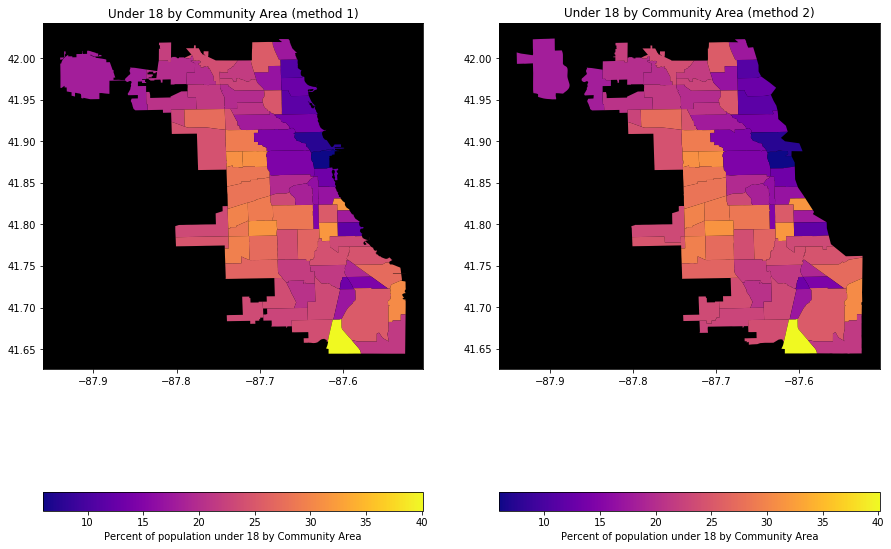

In [18]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15)) 
pct_by_comm_area_geo['pct_under18'] = pct_by_comm_area_geo['pct_under18_E'] * 100 # this is where we intervene to make it display correctly in the map legend
pct_by_comm_area_geo.plot('pct_under18', 
                      ax=ax1, 
                      cmap='plasma', 
                      legend=True, 
                      legend_kwds={
                          'label': "Percent of population under 18 by Community Area",
                          'orientation': "horizontal"
                    })
ax1.set_title('Under 18 by Community Area (method 1)')
ax1.set_facecolor('k')

# make them the same projection along the way
comm_areas_dissolve.to_crs(pct_by_comm_area_geo.geometry.crs).plot('pct_under18', 
                      ax=ax2, 
                      cmap='plasma', 
                      legend=True, 
                      legend_kwds={
                          'label': "Percent of population under 18 by Community Area",
                          'orientation': "horizontal"
                    })
ax2.set_title('Under 18 by Community Area (method 2)')
ax2.set_facecolor('k')

*They should look pretty much the same, except for nuances of the source geographic data.  Notice the slightly finer detail around Chicago's exclaves. Mt Greenwood Cemetery, the black speck surrounded by Chicago in the lower middle of map #1, is missing from map #2, as well as the edges around Norridge and Harwood Heights (near the top left). That's because map #2 includes the complete geography for tracts which cross the city borders.*

*Notice that one bright yellow community area in the lower right, [Riverdale](https://en.wikipedia.org/wiki/Riverdale,_Chicago), clearly stands out from the rest. But Riverdale on the border of the city, where the [cenpy query method](#Cenpy-for-geographic-selection) missed some tracts. If you want another exercise to practice these methods with, adapt the `cenpy.products...from_place()` call to get data for these variables, repeat the summary operations from method 2 above, and render that map. Does Riverdale still stand out? Are there any other visible deviations?*


## Render a ranked list

As you can see from the maps, while one community area ([Riverdale](https://en.wikipedia.org/wiki/Riverdale,_Chicago)) stands out, there are several which appear to be the same color. 
When comparing estimates that have errors, it’s good not to assert that one places ranks higher than another, if, in fact, when the 
margin of error is considered, the order could be different.

Fortunately, the team at the LAT Data Desk has another package for us, [census-error-analyzer](https://github.com/datadesk/census-error-analyzer), 
which encodes the correct comparison method so that you don't have to re-implement it yourself.

**Warning:** For this dataset, many of the values overlap considerably. I'm not satisfied with my crude method for deciding when to break a tie.  At first, I just compared each row to the one above, and only broke the tie when the two were statistically different. This led to a 74-way tie for second place, which doesn't seem useful.  I changed it so that a tie is broken the first time an estimate is statistically different from the first estimate in the tied-set. I certainly wouldn't publish this list, but the basic method may still help see how data "clumps" when error is taken into account. 

In [19]:
# use pd.DataFrame to make a copy instead of a view and thus silence a warning
ranked_comm_areas = pd.DataFrame(pct_by_comm_area_geo[['community', 'pct_under18_E', 'pct_under18_M']])
ranked_comm_areas['rank_absolute'] = ranked_comm_areas['pct_under18_E'].rank(ascending=False).astype(int) # we want biggest to be ranked first, not smallest
ranked_comm_areas.sort_values(by='rank_absolute',inplace=True)


In [20]:
nuanced_rankings = defaultdict(list)

# people grumble about iterating dataframe rows, but I can't figure out how to do this with apply -- can you?
last_tup = None
last_rank = None
for i, row in enumerate(ranked_comm_areas.itertuples()):
    tup = (row.pct_under18_E, row.pct_under18_M)
    different = True
    if last_tup is None or is_statistically_different(last_tup, tup):
        last_rank = i+1
        last_tup = tup # de-indent this by one level to get the 74-way tie for second place
    (mini,maxi) = statistical_range(*tup)
    nuanced_rankings['area_number'].append(row.Index)
    nuanced_rankings['nuanced_rank'].append(last_rank)
    nuanced_rankings['pct_under18_range'].append(f"{mini:.1%} to {maxi:.1%}")
    nuanced_rankings['name'].append(row.community)
    

pd.set_option('display.max_rows',77)
nuanced_df = pd.DataFrame(nuanced_rankings).set_index('area_number').reindex(columns=['nuanced_rank','name','pct_under18_range'])
nuanced_df

,nuanced_rank,name,pct_under18_range
area_number,,,
54,1,Riverdale,36.0% to 44.3%
40,2,Washington Park,29.0% to 34.7%
36,2,Oakland,27.7% to 35.7%
63,2,Gage Park,29.9% to 33.2%
26,2,West Garfield Park,29.1% to 33.3%
27,2,East Garfield Park,29.3% to 33.1%
52,2,East Side,28.5% to 32.8%
57,2,Archer Heights,27.2% to 32.3%
65,2,West Lawn,27.4% to 31.7%


### Plotting the error

The textual list makes it hard to really understand the spread of values, so let's make a chart.

Each set of bars of the same color have the same "nuanced rank." I'm not sure this clarifies a lot!

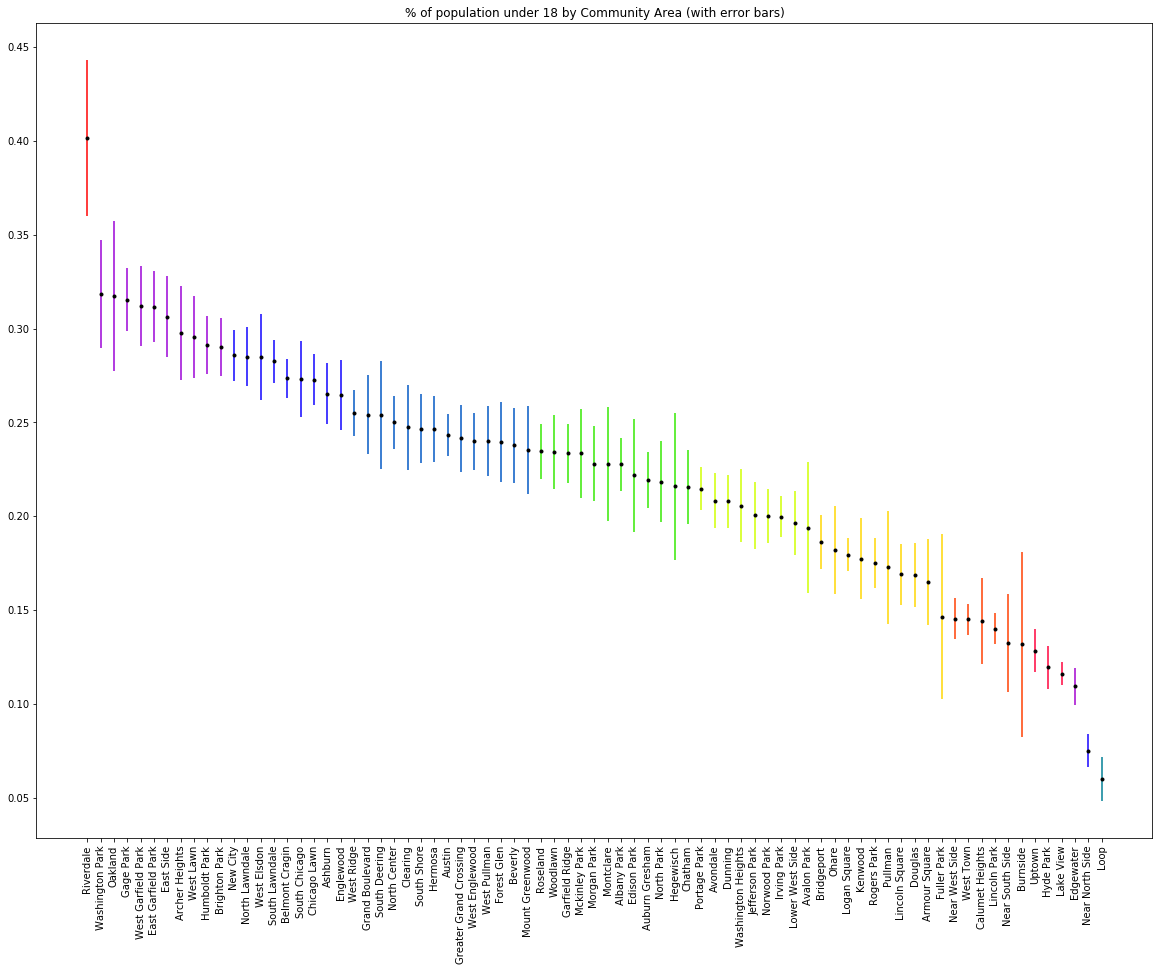

In [21]:
f, ax = plt.subplots(1,1,figsize=(20,15)) 

# add back the actual estimate and error so we can plot error bars
df_errorbars = nuanced_df.join(pct_by_comm_area_geo[['pct_under18_E', 'pct_under18_M']])
df_errorbars.sort_values(by='pct_under18_E',ascending=False,inplace=True)
plt.xticks(rotation=90)
ax.set_title('% of population under 18 by Community Area (with error bars)')

from matplotlib.colors import Normalize
all_ranks = list(df_errorbars['nuanced_rank'].unique())
norm = Normalize(0,len(all_ranks))
for rank, group in df_errorbars.groupby('nuanced_rank'):
    clr = plt.get_cmap('prism')(norm(all_ranks.index(rank)))
    plt.errorbar(group['name'], group['pct_under18_E'], yerr=group['pct_under18_M'], fmt='.k', ecolor=clr);


I think that the moral of this story is that one shouldn't try to make a ranked list of a set of estimates!  But it is good to use the test for statistical difference to see if you're safe saying that one place is "the most/least/biggest/smallest" -- in this case, that part is solid at both ends of the list!